In [1]:
import scipy.io as sio
import pandas as pd
import numpy as np
import torch
from pathlib import Path
import os
import matplotlib.pyplot as plt
import tqdm
import torch.nn as nn
from torch.utils.data import Dataset
from collections import namedtuple
import tqdm
from torchvision.transforms import Resize, Compose, ToPILImage, ToTensor
from PIL import Image
import torch.nn.functional as F
from conv_lstm import ConvLSTM
import neptune
import wandb
from PIL import Image
from matplotlib import cm



In [2]:
# import neptune.new as neptune

# run = neptune.init(project='damiankucharski/SpatioTemportal',
#                    api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJhMWU4MzU5Yi1lYzEwLTRjODUtYTRiYy0zOTA2ZTFhYjVmZmUifQ==') # your credentials
wandb.init(project='anomaly', entity='coinitialized')
#neptune.create_experiment(name='pytorch-run')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: damiankucharski (use `wandb login --relogin` to force relogin)


In [3]:
training_videos_path = Path('Avenue Dataset') / 'training_vol'

In [4]:
training_videos_path / 'vol01.mat'

WindowsPath('Avenue Dataset/training_vol/vol01.mat')

In [5]:
videodata = sio.loadmat(str(training_videos_path / 'vol01.mat'))  

In [6]:
video1 = videodata['vol']


In [7]:
video1.shape

(120, 160, 1364)

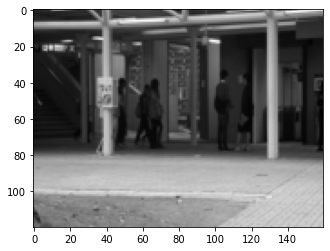

In [8]:
plt.imshow(video1[..., 0], cmap = 'gray')

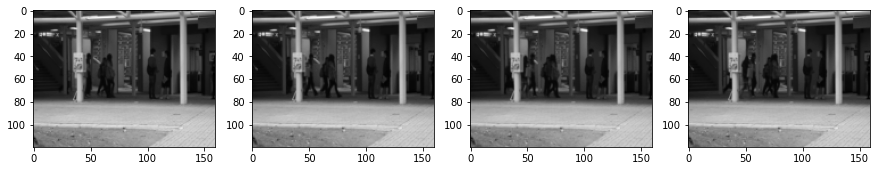

In [9]:
plt.figure(figsize=(15,10))
plt.subplot(1,4,1)
plt.imshow(video1[..., 0], cmap = 'gray')
plt.subplot(1,4,2)
plt.imshow(video1[..., 4], cmap = 'gray')
plt.subplot(1,4,3)
plt.imshow(video1[..., 8], cmap = 'gray')
plt.subplot(1,4,4)
plt.imshow(video1[..., 12], cmap = 'gray')


In [10]:
transform = Compose([ToPILImage(),Resize((227,227)), ToTensor()]) 

def generate_stride_set(video_array, stride_size = 1, window_length = 10):

    end = video_array.shape[-1] - window_length
    windows = []
    for i in tqdm.tqdm(range(0, end, stride_size)):
        x = video_array[..., i:i+window_length]
        transformed_x = []
        for j in range(x.shape[-1]):
            temp = x[..., j]
            temp_transformed = transform(temp)
            transformed_x.append(temp_transformed)
        x = torch.cat(transformed_x)
        windows.append(torch.unsqueeze(x,0))
        # shape  = (10,227,227) 
    
    windows = torch.cat(windows)
    return windows
    



In [11]:
stride_3_set = generate_stride_set(video1, stride_size=3)
stride_1_set = generate_stride_set(video1)
stride_2_set = generate_stride_set(video1, stride_size=2)

100%|██████████| 677/677 [00:04<00:00, 138.79it/s]


In [12]:
stride_3_set.shape

torch.Size([452, 10, 227, 227])

In [13]:
data_set = torch.unsqueeze(torch.cat([stride_1_set, stride_2_set, stride_3_set]),1)
data_set = data_set[torch.randperm(data_set.size()[0])]
data_set.shape

torch.Size([2483, 1, 10, 227, 227])

In [14]:
class SpatialEncoder(nn.Module):

    def __init__(self):
        super(SpatialEncoder, self).__init__()
        self.conv1 = nn.Conv3d(in_channels = 1, out_channels= 128, kernel_size= (1,11,11), stride=(1,4,4))
        self.conv2 = nn.Conv3d(in_channels= 128, out_channels= 64, kernel_size= (1,5,5), stride=(1,2,2))
        self.convlstm = ConvLSTM(input_dim=64,
                 hidden_dim=[64,32,64],
                 kernel_size=(3, 3),
                 num_layers=3,
                 batch_first=True,
                 bias=True,
                 return_all_layers=True)
        self.convt1 = nn.ConvTranspose3d(64, 128,(1,5,5), stride=(1,2,2))
        self.convt2 = nn.ConvTranspose3d(128, 1,(1,11,11), stride=(1,4,4))
    def forward(self, X):

        X = self.conv1(X)
        X = F.tanh(X)
        X = self.conv2(X)
        X = F.tanh(X)
        # batch, channels, time, h, w
        assert X.size()[1:] == torch.Size([64, 10, 26, 26])
        # batch, time, channels, h, w
        X = X.permute([0, 2, 1, 3, 4])
        layer_output_list, last_state_list = self.convlstm(X)
        X = layer_output_list[-1]
        # batch, depth, channels, h, w
        assert X.shape[1:] == torch.Size([10,64,26,26])
        # batch, channels, depth, h, w
        X = X.permute([0, 2, 1, 3, 4])
        X = self.convt1(X)
        X = F.tanh(X)
        X = self.convt2(X)
        X = F.sigmoid(X)
        assert X.shape[1:] == torch.Size([1, 10,227,227])
        return X


In [15]:
class AnomalyDataset(Dataset):
    
    def __init__(self, X, train=True, fraction = 0.8):

        pivot = int(fraction * len(X))
        if train:
            self.X = X[:pivot]
        else:
            self.X = X[pivot:]

    def __len__(self):

        return len(self.X)
    
    def __getitem__(self, ndx):
        return self.X[ndx, ...]




In [16]:
##### TRENOWANIE ######

In [17]:
transfms = Compose([ToPILImage(),Resize((227,227)), ToTensor()]) 

In [18]:
device = torch.device('cuda')
model = SpatialEncoder()
model = model.to(device)


In [19]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters())
loss = nn.MSELoss()
epochs = 500

set_train = AnomalyDataset(data_set, train=True) 
set_test = AnomalyDataset(data_set, train=False)

train_loader = torch.utils.data.DataLoader(set_train, batch_size=12, shuffle=True)
test_loader = torch.utils.data.DataLoader(set_test, batch_size=12, shuffle=True)


In [20]:
losses_train = []
losses_test = []

In [21]:
for i in tqdm.tqdm(range(epochs)):

  print('train')
  batch_loss_train = []
  model.train()
  for X_batch in train_loader:
    optimizer.zero_grad()
    X_batch = X_batch.to(device)
    predictions = model(X_batch)
    loss_val = loss(predictions, X_batch)
    batch_loss_train.append(loss_val.item())
    loss_val.backward()
    optimizer.step()
  losses_train.append(np.mean(batch_loss_train))


  print('test')

  model.eval()
  batch_loss_test = []
  for X_batch in test_loader:
    X_batch = X_batch.to(device)
    predictions = model(X_batch)
    loss_val = loss(predictions, X_batch)
    batch_loss_test.append(loss_val.item())

  output_image = predictions[:1,...]
  output_image = output_image.squeeze()
  one_frame = output_image[0,...]
  one_frame_numpy = one_frame.cpu().detach().numpy()
  im = Image.fromarray(np.uint8(cm.gist_earth(one_frame_numpy)*255))
  
  wandb.log({"loss_train": np.mean(batch_loss_train),"loss_test": np.mean(batch_loss_test), "epoch": i,
           "inputs": wandb.Image(im),
           })

  losses_test.append(np.mean(batch_loss_test))


    if losses_test[i-5] - losses_test[i-1] < 0.00025:
      break



  0%|          | 0/500 [00:00<?, ?it/s]train
C:\Users\cdami\Anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
C:\Users\cdami\Anaconda3\lib\site-packages\torch\nn\functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
test
  0%|          | 1/500 [01:55<16:03:56, 115.90s/it]train
test
  0%|          | 2/500 [03:48<15:54:17, 114.97s/it]train
test
  1%|          | 3/500 [05:40<15:44:36, 114.04s/it]train
test
  1%|          | 4/500 [07:32<15:38:42, 113.55s/it]train
test
  1%|          | 5/500 [09:20<15:21:53, 111.74s/it]train
test
  1%|          | 6/500 [11:08<15:09:42, 110.49s/it]train
test
  1%|▏         | 7/500 [12:56<15:01:59, 109.78s/it]train
test
  2%|▏         | 8/500 [14:43<14:54:18, 109.06s/it]train
test
  

KeyboardInterrupt: 

In [22]:
x = next(iter(train_loader))

In [23]:
x.shape

torch.Size([12, 1, 10, 227, 227])

In [24]:
torch.mean(model(x.to(device)))

tensor(0.3998, device='cuda:0', grad_fn=<MeanBackward0>)

In [25]:
import matplotlib.pyplot as plt

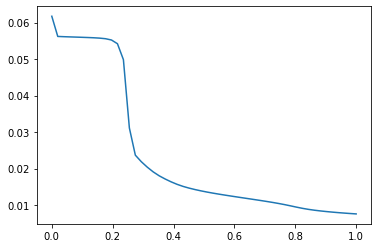

In [26]:
plt.plot(np.linspace(0,1,len(losses_train)), losses_train)

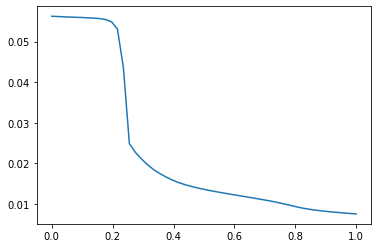

In [27]:
plt.plot(np.linspace(0,1,len(losses_train)), losses_test)

In [28]:
x[:1,...].shape
out = model(x[:1,...].to(device))

C:\Users\cdami\Anaconda3\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [29]:
input = x[:1,...]
input = input.squeeze()
one_frame = input[0,...]
one_frame_numpy = one_frame.numpy()

In [30]:
out = out.to(torch.device('cpu'))

In [31]:
out = out.squeeze()[0,...].squeeze().detach().numpy()

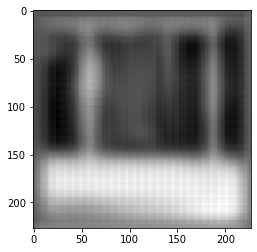

In [32]:
plt.imshow(out, cmap='gray')

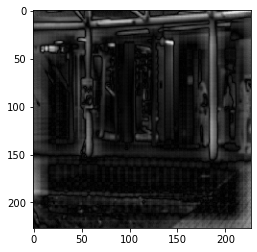

In [33]:
plt.imshow(abs(one_frame_numpy - out), cmap='gray')

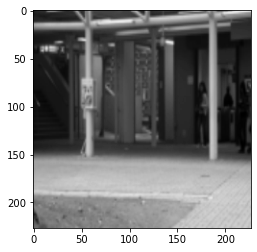

In [34]:
plt.imshow(one_frame_numpy, cmap='gray')

In [35]:
out

array([[0.3409029 , 0.34934115, 0.3485112 , ..., 0.363836  , 0.35225546,
        0.37023926],
       [0.32841957, 0.3458663 , 0.35272408, ..., 0.37623858, 0.35229403,
        0.35871473],
       [0.330314  , 0.346387  , 0.3132883 , ..., 0.3485484 , 0.34279248,
        0.3534558 ],
       ...,
       [0.36267114, 0.3541303 , 0.38649735, ..., 0.40888926, 0.4261089 ,
        0.393369  ],
       [0.40074253, 0.37225434, 0.37039337, ..., 0.3955277 , 0.4042198 ,
        0.4147302 ],
       [0.37499392, 0.3759646 , 0.3807612 , ..., 0.41555375, 0.41874132,
        0.41965258]], dtype=float32)

In [36]:
3

3